In [28]:
import numpy as np
import matplotlib.pyplot as plt
import croissant as cro
from astropy.time import Time
from astropy import units as u
import healpy as hp

%matplotlib widget

In [33]:
npz = np.load("/home/christian/Documents/research/eigsep/eigsep_vivaldi.npz")
beam = npz["bm"]
freqs = npz["freqs"] / 1e6
nside = npz["nside"]
#lmax = 3 * nside - 1 
lmax = 64
#lmax = 15
print(nside, lmax)

TIME = Time("2025-02-27 10:24:01")
lat, lon = (39.2480857349511, -113.40368874682412)
LOC = (lon, lat)

sky = cro.Sky.gsm(freqs, lmax=lmax)
sky.switch_coords("C")

beam_alm = cro.healpix.map2alm(beam, lmax=lmax)
beam = cro.Beam(beam_alm, lmax=lmax, frequencies=freqs, coord="T")
beam.horizon_cut(nside=nside)
beam.switch_coords("C", loc=LOC, time=TIME)

64 64


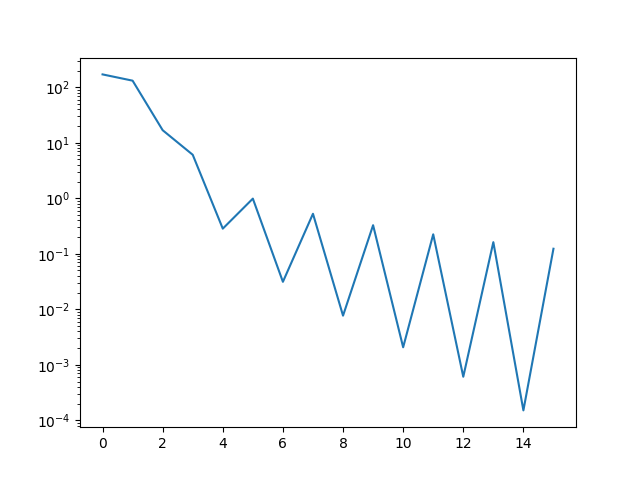

In [30]:
ells = hp.Alm.getlm(lmax)[0]
tot_lm = np.zeros(lmax+1)
for i, ell in enumerate(ells):
    tot_lm[ell] += np.abs(beam.alm[0, i])**2

plt.figure()
plt.plot(np.arange(lmax+1), tot_lm)
plt.yscale("log")
plt.show()

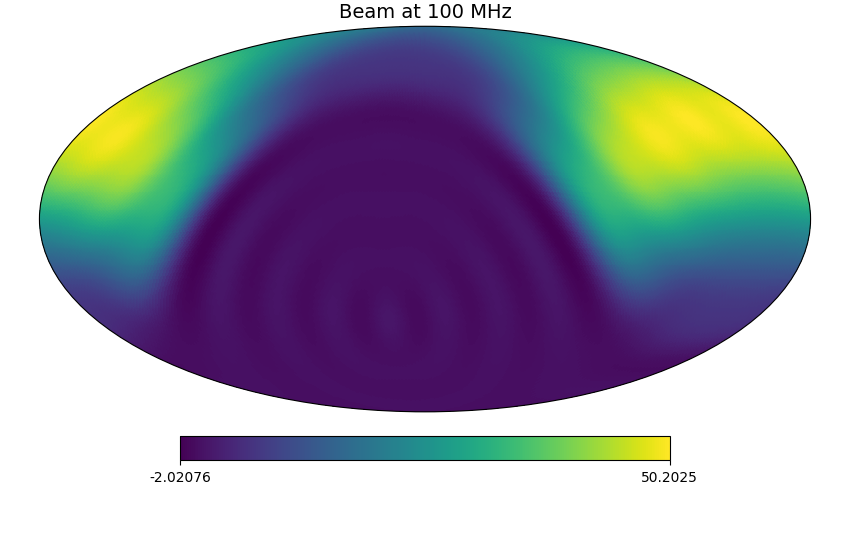

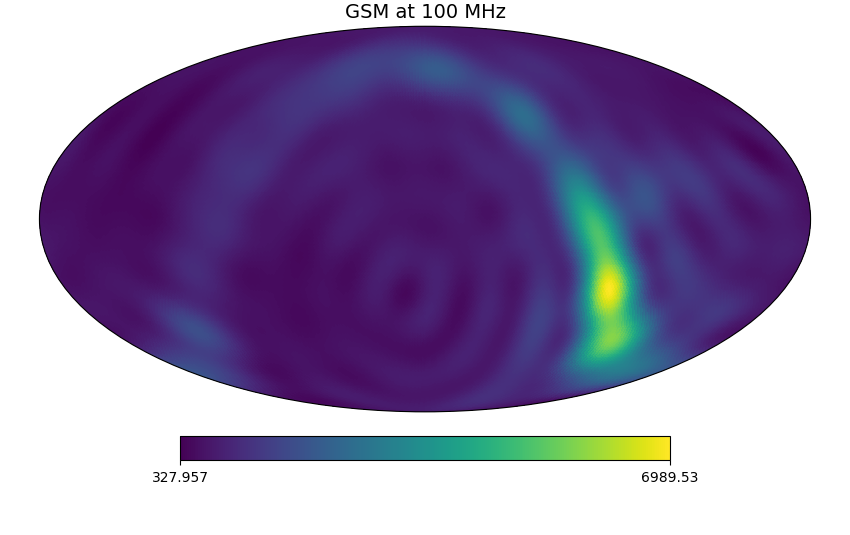

In [31]:
plot_ix = 50
plot_freq = freqs[plot_ix]
hp.projview(beam.hp_map(nside, frequencies=[plot_freq])[0], title=f"Beam at {plot_freq:.0f} MHz")
plt.show()

hp.projview(sky.hp_map(nside, frequencies=[plot_freq])[0], title=f"GSM at {plot_freq:.0f} MHz")
plt.show()

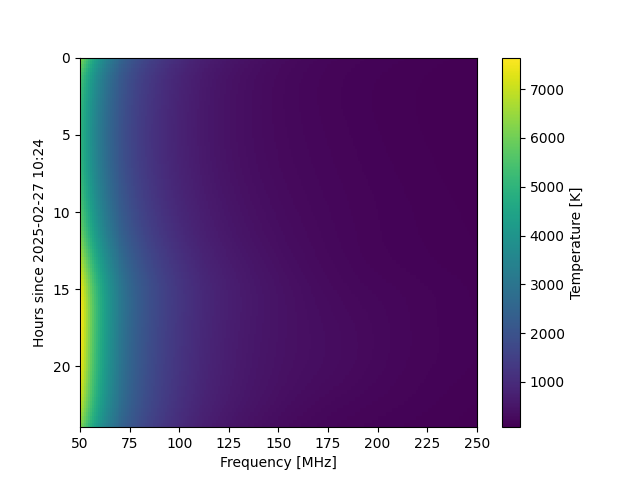

In [32]:
t_end = TIME + cro.constants.sidereal_day_earth * u.s
times = cro.utils.time_array(t_start=TIME, t_end=t_end, N_times=100)
sim = cro.Simulator(beam, sky, lmax=lmax, frequencies=freqs, world="earth", times=times)

sim.run(dpss=False)
sim.plot()

Trying to reproduce CROISSANT results with a big matrix.

In [6]:
def extend_alm(arr):
    """
    Add negative m-modes.
    Healpy doesn't include the negative m-modes, since they can be derived from the positive ones, this adds them explictly.

    arr can have multiple dimensions as long as the alm-dimension is the last one.
    
    """
    lmax = hp.Alm.getlmax(arr.shape[-1])
    emms = hp.Alm.getlm(lmax)[1]
    m0_modes = arr[..., :lmax+1]
    mpos_modes = arr[..., lmax+1:]
    mneg_modes = (-1)**emms[lmax+1:] * mpos_modes.conj()
    arr2 = np.concatenate((m0_modes, mpos_modes, mneg_modes), axis=-1)
    return arr2


def reduce_alm(arr, lmax):
    """
    Invert the function above.
    """
    s = hp.Alm.getsize(lmax)
    return arr[..., :s]

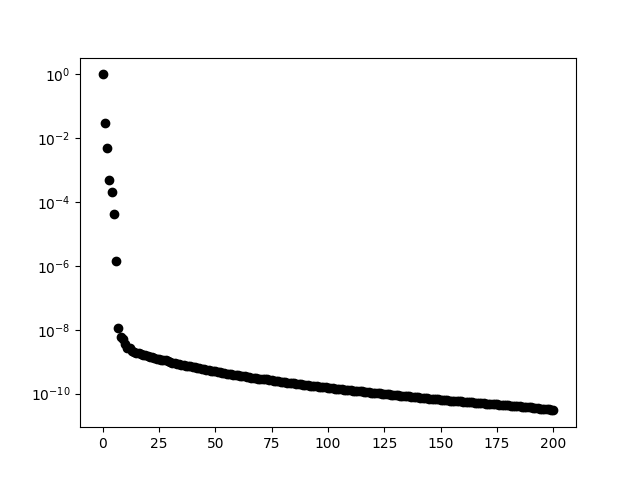

7


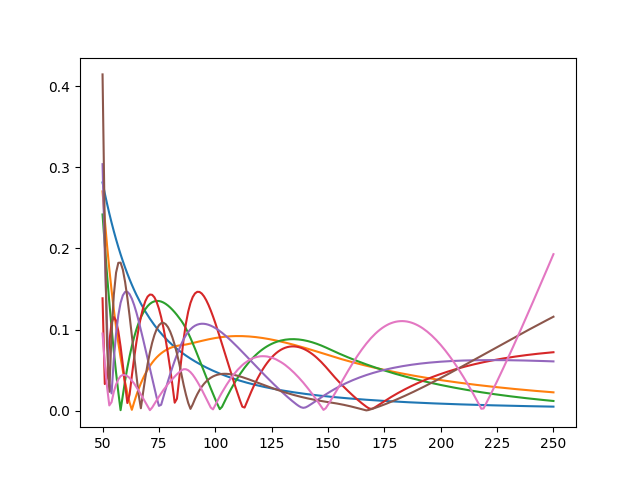

0.006058913549231099

In [7]:
u, s, vh = np.linalg.svd(sky.alm.conj().T)

plt.figure()
plt.plot(s/s[0], marker="o", ls="none", c="k")
plt.yscale("log")
plt.show()

#Nmodes = np.count_nonzero(s/s[0] > 1e-16)
Nmodes = 7
print(Nmodes)
vh = vh[:Nmodes]
v = vh.conj().T
plt.figure()
plt.plot(freqs, np.abs(vh).T)
plt.show()


sky_pca = sky.alm.conj().T @ v
recon = sky_pca @ vh

#sky_pca = vh @ sky.alm.conj()
#recon = v @ sky_pca

np.max(np.abs(sky.alm.conj() - recon.T) / np.abs(sky.alm.conj()))

In [8]:
# use sparse linear operators to compute the sky estimator
from scipy.sparse.linalg import LinearOperator, lsqr

# using frequency
# xvec = extend_alm(sky.alm.conj()).T.ravel()

# using gsm
xvec = extend_alm(sky_pca.T).T.ravel()

phases = sim.sky.rot_alm_z(times=sim.dt, world="earth")
Nf = sim.frequencies.size
Nt = sim.times.size
r = np.concatenate((phases[:, :lmax+1], phases.conj()[:, lmax+1:], phases[:, lmax+1:]), axis=1)  # conj(e^imphi) for emm=0, emm>0, emm<0
r = r.T  # shape is N_alm, Nt
beam.compute_total_power()
norm = beam.total_power
b = extend_alm(beam.alm).T  # shape is (N_alm, Nf)
N_alm = b.shape[0]  # extended alm with negative ms

# using frequency
# design_shape = (Nf * Nt, Nf * N_alm)

# using gsm
design_shape = (Nf * Nt, Nmodes * N_alm)

def matvec(c):
    """
    Compute the matrix product A @ c for a vector c representing sky-coefficients in the space spanned by GSM-modes and spherical harmonics.

    A is the design matrix (of beam alm and rotation phases) that sends sky to waterfall.

    We assume c is flattened.
    
    """
    # using gsm modes
    a = c.reshape(N_alm, Nmodes) @ vh
    
    # using freq
    # a = c.reshape(N_alm, Nf)
    
    arot = r[:, :, None] * a[:, None, :]
    y = np.sum(arot * b[:, None, :], axis=0)
    y = y / norm[None, :]
    return y.ravel()


def rmatvec(u):
    """
    Compute the adjoint operation X^H @ u.
    
    u is a vector of length Nt * Nf, which we interpret as U[t, f]
    with shape (Nt, Nf). The design matrix X is defined so that:
    
      y[t, f] = sum_{i,k} r[t,i] * b[i,f] * sky_modes[k,f] * c[i,k],
      
    and so the adjoint is:
    
      (X^H u)[i,k] = sum_{t,f} conj(r[t,i]) * conj(b[i,f]) * conj(sky_modes[k,f]) * u[t,f].
      
    This function returns a flattened vector corresponding to the (N_alm, Nmodes) output.
    """
    um = u.reshape(Nt, Nf)  # shape: (Nt, Nf)
    temp = np.einsum('ti,tf->if', r.T.conj(), um)  # shape: (N_alm, Nf)
    c_est = temp * b.conj() / norm[None, :]

    # only include if using gsm modes
    c_est = c_est @ v
    
    return c_est.ravel()


A_op = LinearOperator(design_shape, matvec=matvec, rmatvec=rmatvec, dtype=np.complex128)

0.45562226383769966
False
0.0007886613128200715


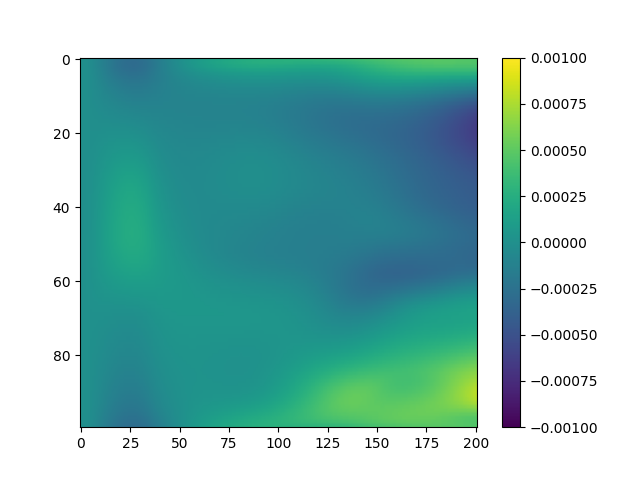

In [9]:
# compare to croissant
yvec = A_op @ xvec
print(np.max(yvec.imag))
y = yvec.real.reshape(Nt, Nf)
print(np.allclose(y, sim.waterfall))
print(np.max(np.abs(1 - y/sim.waterfall)))
plt.figure()
plt.imshow((y-sim.waterfall)/sim.waterfall, aspect="auto", vmin=-1e-3, vmax=1e-3)
plt.colorbar()
plt.show()

In [10]:
# ensure that matvec and rmatvec indeed are hermitian adjoints
Axy = np.vdot(matvec(xvec), yvec)  # Ax dot y
xAhy = np.vdot(xvec, rmatvec(yvec))  # x dot (A^H)y
print(np.allclose(Axy, xAhy))

True


In [11]:
sol = lsqr(A_op, y.ravel().astype(complex))
x_est = np.reshape(sol[0], (N_alm, Nmodes)).copy()  # estimated solution, shape: (M*Nmodes,)

# convert to frequency and pixel
x_est = x_est @ vh
x_est = reduce_alm(x_est.T, lmax)

sky_hat = cro.healpix.alm2map(x_est.conj().copy(), nside, lmax=lmax)

In [16]:
sol[1:]

(1,
 875,
 4.926591333172113,
 4.926591333172113,
 67.36209066302989,
 49432.55946597812,
 0.32428301916849994,
 69884.77881378887,
 array([0., 0., 0., ..., 0., 0., 0.]))

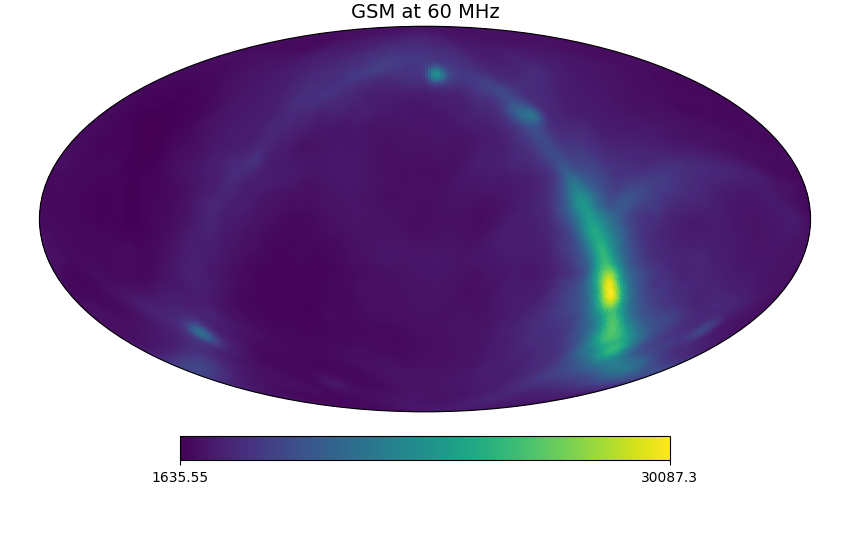

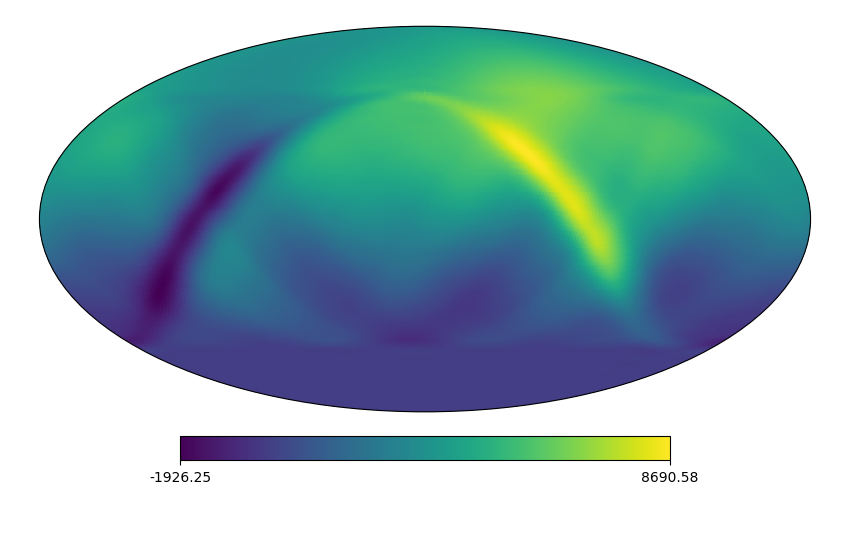

In [12]:
plot_ix = 10
plot_freq = freqs[plot_ix]

hp.projview(sky.hp_map(nside, frequencies=[plot_freq])[0], title=f"GSM at {plot_freq:.0f} MHz")
plt.show()
hp.projview(sky_hat[plot_ix])
plt.show()

In [13]:
def AHA_matvec(x):
    return A_op.rmatvec(A_op.matvec(x))

n = A_op.shape[1]
AHA = LinearOperator((n, n), matvec=AHA_matvec, dtype=A_op.dtype)

In [18]:
n

29575

In [19]:
from scipy.sparse.linalg import eigsh

k = 300
eigvals, eigvecs = eigsh(AHA, k=k, which='LM')

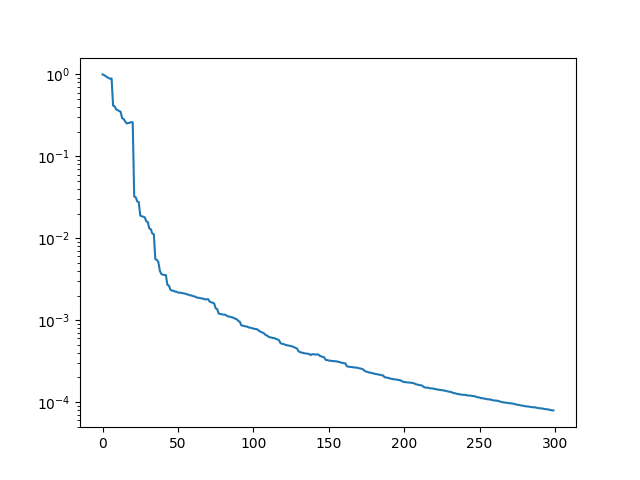

In [21]:
plt.figure()
plt.plot(eigvals/eigvals[0])
plt.yscale("log")
plt.show()

# THRESH = 1e-7
# err = (np.sum(eigvals) - np.cumsum(eigvals)) / np.sum(eigvals)
# NVECS = np.nonzero(err<THRESH)[0].min()
# print(NVECS)

In [46]:
np.allclose(eigvecs.reshape(N_alm, Nmodes, -1).reshape(N_alm, -1), eigvecs.reshape(N_alm, -1))

True

In [49]:
hp.Alm.getsize(lmax)

2145

In [53]:
design_modes = reduce_alm(eigvecs.reshape(N_alm, -1).T, lmax).T.reshape(-1, Nmodes, k)
design_modes = np.swapaxes(design_modes, 1, 2) @ vh
NPLOT = 5
design_modes = design_modes[:, :NPLOT, :].reshape(-1, NPLOT * Nf)

design_maps = cro.healpix.alm2map(design_modes.T.copy(), nside, lmax=lmax).T.reshape(-1, NPLOT, Nf)

#design_modes = design_modes.reshape(-1, k * Nf)
#
#design_

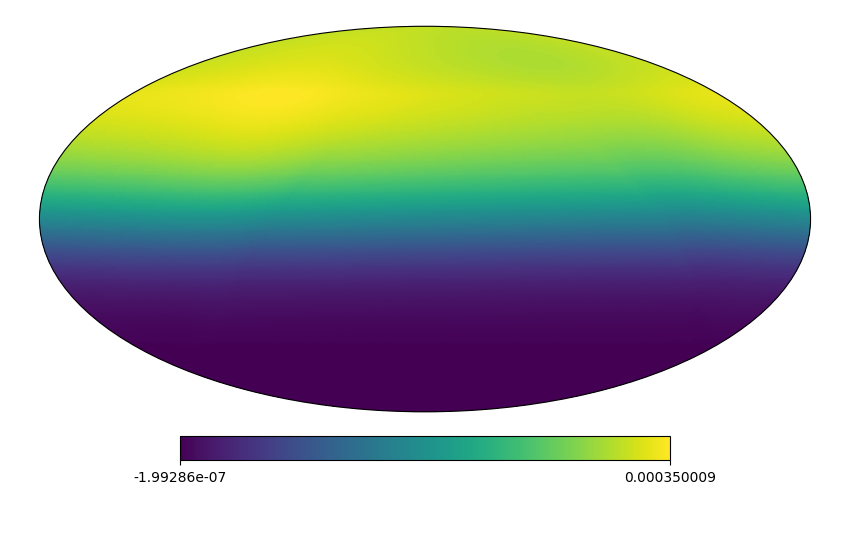

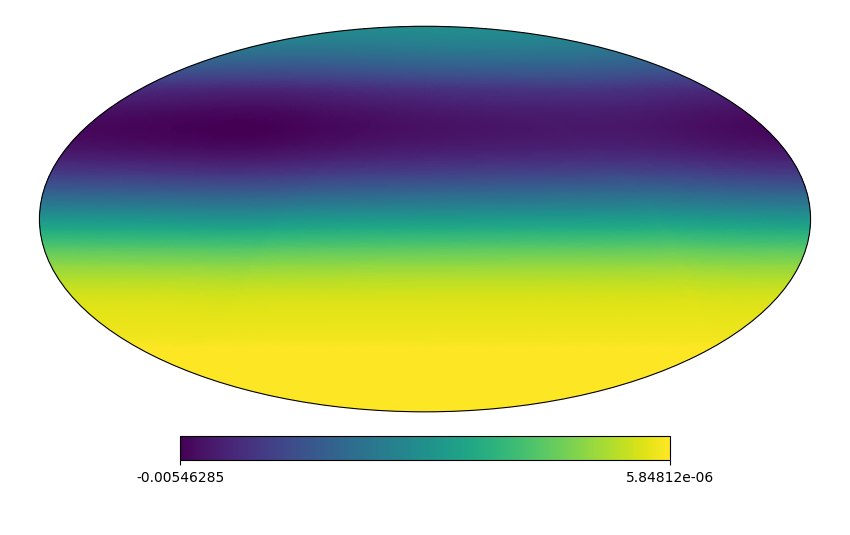

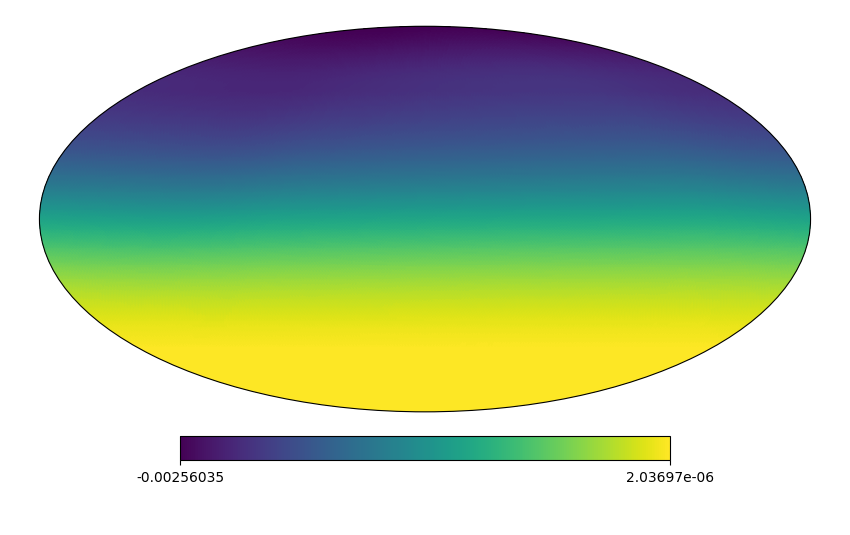

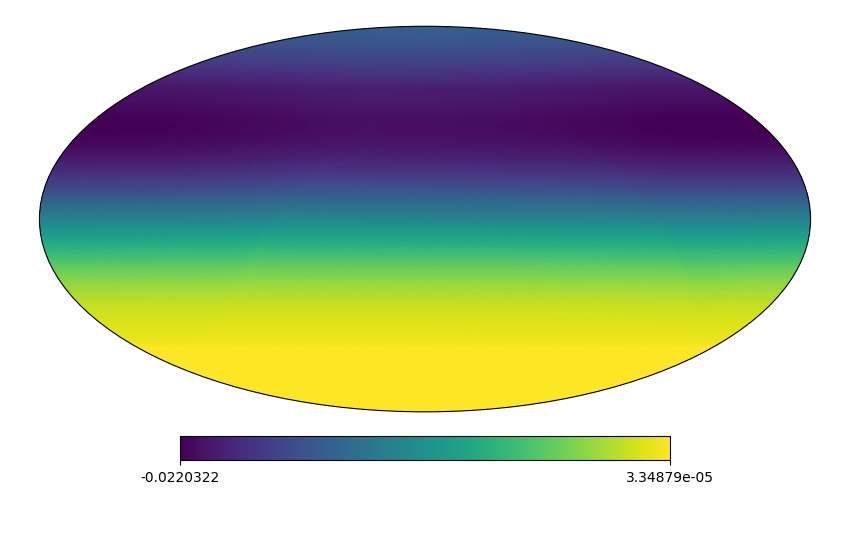

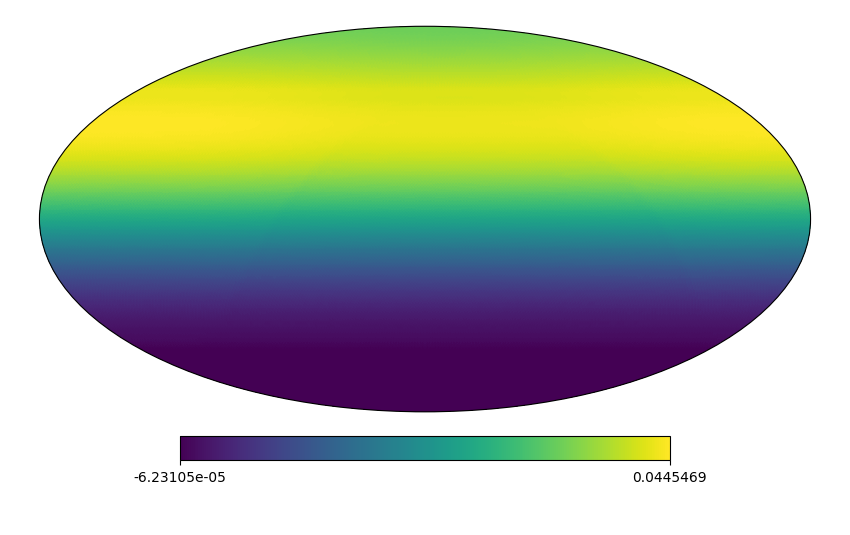

In [65]:
hp.projview(design_maps[:, 0, 0])
hp.projview(design_maps[:, 1, 0])
hp.projview(design_maps[:, 2, 0])
hp.projview(design_maps[:, 3, 0])
hp.projview(design_maps[:, 4, 0])

In [67]:
design_maps.shape

(49152, 5, 201)

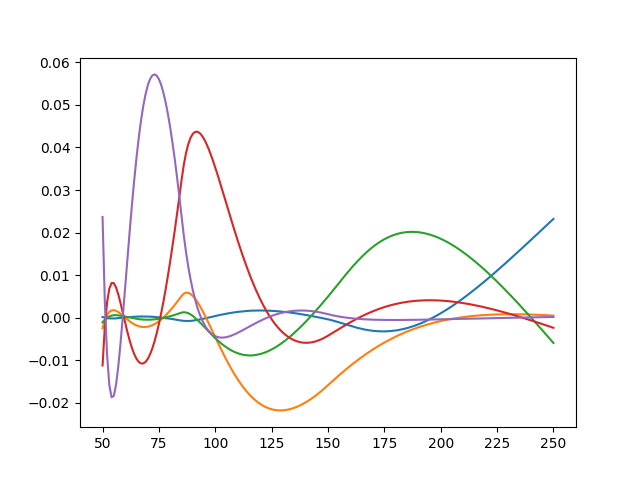

In [68]:
plt.figure()
plt.plot(freqs, design_maps.mean(axis=0).T)
plt.show()

In [ ]:
# decompose A = U Sigma V^H
Vmat = eigvecs[:, :NVECS]
Sigma = np.sqrt(eigvals[:NVECS])
print(Sigma.shape, Vmat.shape)
A_eigen = A_op @ Vmat
x_eigen = Vmat.conj().T @ xvec

In [ ]:
A_op.shape

### Regularization

In [25]:
lam = 1e-2
ell, emm = hp.Alm.getlm(lmax)
all_ell = np.repeat(np.concatenate((ell, ell[emm>0])), Nmodes)
print(ell.shape, all_ell.shape, xvec.shape)
reg_mat = lam * all_ell * (all_ell+1)

def B_matvec(x):
    inv_mat = AHA + np.abs(reg_mat)**2
    return np.linalg.inv(inv_mat) @ AHA.matvec(x)

reg_op = LinearOperator(AHA.shape, matvec=B_matvec, dtype=AHA.dtype)

x_est_reg = reg_op @ sol[0]


(2145,) (29575,) (29575,)


ValueError: dimension mismatch: (29575, 29575), (4225, 7)

In [27]:
sol[0].shape

(4225, 7)

In [ ]:

x_est_reg.shape = (N_alm, Nmodes)

# convert to frequency and pixel
x_est_reg = x_est_reg @ vh
x_est_reg = reduce_alm(x_est._reg.T, lmax)

sky_hat_reg = cro.healpix.alm2map(x_est_reg.conj().copy(), nside, lmax=lmax)